In [1]:
# collect data and get models to predict credibility score
import collections
import copy
import itertools
import libsbml
import numpy as np
import os
import pickle
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline  

BIOMD_12 = 'BIOMD0000000012.xml'
BASE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/'
DATA_DIR = os.path.join(BASE_DIR, "DATA")
ALGO_DIR = os.path.join(DATA_DIR, "algo")
CHEBI_DIR = os.path.join(DATA_DIR, "chebi")
RHEA_DIR = os.path.join(DATA_DIR, "rhea")
BIOMODEL_DIR = os.path.join(DATA_DIR, "biomodels/curated_biomodels_31mar2021")
BIGG_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/DATA/bigg'
ecoli_fpath = os.path.join(BIGG_DIR, "e_coli_core.xml")

PROJ_DIR = os.path.join(os.getcwd(), os.pardir)
AMAS_DIR = os.path.join(PROJ_DIR, "AMAS")
sys.path.append(PROJ_DIR)

SUPPL_DIR = os.path.join(PROJ_DIR, os.pardir, "AMAS_suppl")
ACCURACY_DIR = os.path.join(SUPPL_DIR, "data_for_credibility")

from AMAS import species_annotation as sa
from AMAS import reaction_annotation as ra
from AMAS import recommender
from AMAS import constants as cn
from AMAS import iterator as it
from AMAS import tools

In [2]:
# reader = libsbml.SBMLReader()
# document = reader.readSBML(one_fpath)
# model = document.getModel()

In [3]:
# one_species = model.getListOfSpecies()[0]

## Data for species prediction

In [4]:
biomds = [val for val in os.listdir(BIOMODEL_DIR) if val[-4:]=='.xml']

In [8]:
model_names = []
len_names = []
num_cands = []
num_formulas = []
match_scores = []
is_correct_included = []
#
for idx, one_biomd in enumerate(biomds):
  if idx % 100 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  specs2evaluate = list(recom.species.exist_annotation_formula.keys())
  # run algorithm if there is at least one species to evaluate
  if specs2evaluate:
    recoms = recom.getSpeciesListRecommendation(pred_ids=recom.species.exist_annotation_formula.keys())
    recalls = recom.getSpeciesStatistics(model_mean=False)[cn.RECALL]
    for one_recom in recoms:
      model_names.append(one_biomd)
      one_spec = one_recom.id
      len_names.append(len(recom.species.getNameToUse(one_spec)))
      num_cands.append(len(one_recom.candidates))
      num_formulas.append(len(recom.species.formula[one_recom.id]))
      match_scores.append(one_recom.candidates[0][1])
      if recalls[one_spec] > 0:
        is_correct_included.append(1)
      else:
        is_correct_included.append(0)

We are at 0
We are at 100
We are at 200
We are at 300
We are at 400
We are at 500
We are at 600
We are at 700
We are at 800
We are at 900


In [10]:
spec_df = pd.DataFrame({'model': model_names,
                        'name_length': len_names,
                        'num_candidates': num_cands,
                        'num_formulas': num_formulas,
                        'match_score': match_scores,
                        'accuracy': is_correct_included})

In [33]:
spec_df.head()

,model,name_length,num_candidates,num_formulas,match_score,accuracy
0,BIOMD0000000634.xml,3,6,5,1.000,1
1,BIOMD0000000634.xml,3,13,11,1.000,1
2,BIOMD0000000634.xml,3,14,12,1.000,1
3,BIOMD0000000152.xml,2,7,5,1.000,1
4,BIOMD0000000152.xml,15,1,1,0.873,0


In [11]:
spec_df.shape

(4902, 6)

In [12]:
spec_df.to_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_species_accuracy.csv'), index=False)

In [5]:
# spec_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_species_accuracy.csv'))
# spec_df.shape

In [13]:
len(np.unique(spec_df['model']))

306

In [14]:
np.sum(spec_df['accuracy']) / spec_df.shape[0]

0.6015911872705019

## Cross validation score will be computed using three classifiers
## 1. RandForest, 2. AdaBoost, 3. SVC 
## and the best performing one was chosen. 

In [15]:
from sklearn.model_selection import cross_val_score
X = spec_df.iloc[:,1:-1].to_numpy()
y = spec_df.loc[:,'accuracy']

In [18]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10)
print("AdaBoost 10-Fold CV Score", np.mean(scores))

AdaBoost 10-Fold CV Score 0.8737366474084542


In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
scores = cross_val_score(clf, X, y, cv=10)
print("SVC 10-Fold CV Score", np.mean(scores))

SVC 10-Fold CV Score 0.8547732657217673


In [25]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10)
print("RandomForest 10-Fold CV Score", np.mean(scores))

RandomForest 10-Fold CV Score 0.8712939024897128


In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X, y)
print(clf.predict_proba(X))

[[0.19732619 0.80267381]
 [0.08437177 0.91562823]
 [0.08437177 0.91562823]
 ...
 [0.0359217  0.9640783 ]
 [0.05319045 0.94680955]
 [0.96332851 0.03667149]]


In [27]:
# classes_ scores predicted label for predict_proba
clf.classes_

array([0, 1])

(array([ 823.,  617.,  262.,   74.,   60.,  137.,  207.,  387.,  443.,
        1892.]),
 array([0.02231631, 0.11782878, 0.21334124, 0.30885371, 0.40436618,
        0.49987864, 0.59539111, 0.69090357, 0.78641604, 0.88192851,
        0.97744097]),
 <BarContainer object of 10 artists>)

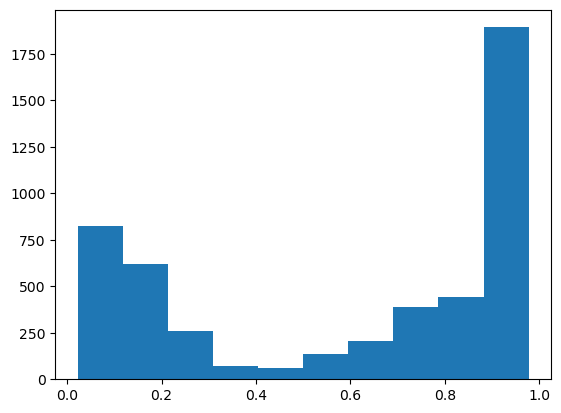

In [28]:
# more dynamic with RForest
plt.hist(pd.DataFrame(clf.predict_proba(X))[1])

In [29]:
# Save model
import compress_pickle
compress_pickle.dump(clf,
                     os.path.join(cn.REF_DIR, 'species_rf_fitted.lzma'), 
                     compression="lzma", set_default_extension=False)

In [30]:
one_ml = compress_pickle.load(os.path.join(cn.REF_DIR, 'species_rf_fitted.lzma'))

In [31]:
one_ml.predict_proba([[1, 2, 3, 4]])

array([[0.84372661, 0.15627339]])

In [37]:
clf.feature_importances_

array([0.13316645, 0.09327187, 0.02793352, 0.74562817])

## Data for Reactions Prediction

In [39]:
def getRheaElementNum(inp_rhea, inp_df=ra.REF_MAT):
  """
  Get Number of elements of
  the given rhea term.
  
  Parameters
  ----------
  inp_rhea: str
  
  Returns
  -------
  : int
  """
  return len(inp_df.loc[inp_rhea, :].to_numpy().nonzero()[0])

model_names = []
num_rhea_eles = []
num_query_eles = []
num_candidates = []
val_match_scores = []
is_correct_included = []


for idx, one_biomd in enumerate(biomds):
  if idx % 100 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  reac2evaluate = list(recom.reactions.exist_annotation.keys())
  if reac2evaluate:  
    recoms = recom.getReactionListRecommendation(pred_ids=reac2evaluate)
    recalls = recom.getReactionStatistics(model_mean=False)[cn.RECALL]
    for one_recom in recoms:
      reaction_id = one_recom.id
      match_scores = [val[1] for val in one_recom.candidates]
      num_ref_elements = [getRheaElementNum(val[0]) for val in one_recom.candidates]
      #
      mean_num_rhea_elements = np.mean(num_ref_elements)   
      # this is actually the number of reaction components;
      num_query_ele = len(recom.reactions.reaction_components[reaction_id])
      num_cands = len(match_scores)
      mean_match_score = np.mean(match_scores)
      #
      model_names.append(one_biomd)
      num_rhea_eles.append(mean_num_rhea_elements)
      num_query_eles.append(num_query_ele)
      num_candidates.append(num_cands)
      val_match_scores.append(mean_match_score)
      if recalls[reaction_id] > 0.0:
        is_correct_included.append(1)
      else:
        is_correct_included.append(0)

We are at 0
We are at 100
We are at 200
We are at 300
We are at 400
We are at 500
We are at 600
We are at 700
We are at 800
We are at 900


In [40]:
reac_df = pd.DataFrame({'model': model_names,
                        'mean_num_rhea_elements': num_rhea_eles,
                        'num_query_elements': num_query_eles,
                        'num_candidates': num_candidates,
                        'match_score': val_match_scores,
                        'accuracy': is_correct_included})
reac_df.head()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
0,BIOMD0000000152.xml,5.111111,3,9,0.209556,0
1,BIOMD0000000152.xml,4.732143,3,56,0.237464,0
2,BIOMD0000000152.xml,4.560000,3,25,0.222000,0
3,BIOMD0000000152.xml,5.340426,3,94,0.195660,0
4,BIOMD0000000152.xml,4.000000,3,1,0.500000,0


In [45]:
reac_df_prev.tail()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
2183,BIOMD0000000177.xml,5.923077,4,13,0.522385,1
2184,BIOMD0000000177.xml,6.813559,3,59,0.300085,0
2185,BIOMD0000000177.xml,4.750000,4,4,0.450000,1
2186,BIOMD0000000177.xml,6.042553,3,47,0.523255,1
2187,BIOMD0000000177.xml,6.000000,3,1,0.333000,0


In [47]:
np.mean(reac_df['accuracy'])

0.6416819012797075

In [48]:
# data was saved somewhere else
# reac_df.to_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_reactions_accuracy.csv'), index=False)

In [52]:
reac_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_reactions_accuracy.csv'))

In [53]:
len(np.unique(reac_df['model']))

131

In [54]:
from sklearn.model_selection import cross_val_score
X = reac_df.iloc[:,1:-1].to_numpy()
y = reac_df.loc[:,'accuracy']

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10)
print("RandomForest 10-Fold CV Score", np.mean(scores))

RandomForest 10-Fold CV Score 0.810762012483767


(array([248.,  96.,  73., 115., 148., 177., 238., 285., 230., 578.]),
 array([0.05465006, 0.14816086, 0.24167166, 0.33518246, 0.42869326,
        0.52220406, 0.61571486, 0.70922566, 0.80273646, 0.89624726,
        0.98975806]),
 <BarContainer object of 10 artists>)

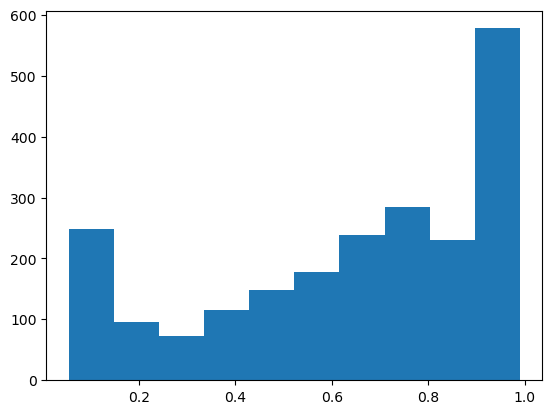

In [55]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X, y)
# print(clf.predict_proba(X))
plt.hist(pd.DataFrame(clf.predict_proba(X))[1])

In [56]:
# Save model
import compress_pickle
# compress_pickle.dump(clf,
#                      os.path.join(cn.REF_DIR, 'reactions_rf_fitted.lzma'), 
#                      compression="lzma", set_default_extension=False)

In [57]:
clf.feature_importances_

array([0.136844  , 0.11755676, 0.19563893, 0.54996031])

In [23]:
recom = recommender.Recommender(libsbml_fpath=ecoli_fpath)
reac2evaluate = list(recom.reactions.exist_annotation.keys())

pred_ids = reac2evaluate
specs_to_annotate = list(set(itertools.chain(*[recom.reactions.reaction_components[val] \
                                                   for val in pred_ids])))
pred_formulas = {}
remaining_species = [val for val in specs_to_annotate]
spec_results = recom.getSpeciesListAnnotation(pred_ids=remaining_species,
                                               update=True)
for one_recom in spec_results:
  chebis = [val[0] for val in one_recom.candidates]
  forms = list(set([cn.REF_CHEBI2FORMULA[k] \
            for k in chebis if k in cn.REF_CHEBI2FORMULA.keys()]))
  pred_formulas[one_recom.id] = forms


pred_result = recom.reactions.predictAnnotation(inp_spec_dict=pred_formulas,
                                                  inp_reac_list=reac2evaluate)

In [67]:
candidates_dict = pred_result[cn.CANDIDATES]
match_score_dict = pred_result[cn.MATCH_SCORE]
mean_rheas_num_dict = {one_k: np.mean([getRheaElementNum(val) \
                                       for val in candidates_dict[one_k]]) \
                       for one_k in candidates_dict.keys()}
num_reac_comp_dict = {one_k: len(recom.reactions.reaction_components[one_k]) \
                      for one_k in candidates_dict.keys()}
num_candidates = {one_k: len(candidates_dict[one_k]) \
                      for one_k in candidates_dict.keys()}
mean_match_scores = {one_k: np.mean([val[1] for val in match_score_dict[one_k]]) \
                      for one_k in candidates_dict.keys()}
df2pred = pd.DataFrame([mean_rheas_num_dict,
                        num_reac_comp_dict,
                        num_candidates,
                        mean_match_scores]).T
cred_pred = REACTION_RF.predict_proba(df2pred)
prob_1_dict = {val: cred_pred[idx][1] for idx, val in enumerate(df2pred.index)}
# return prob_1_dict

Recommendation(id='ODC', credibility=0.817, candidates=[('RHEA:28830', 1.0), ('RHEA:22967', 0.5), ('RHEA:59051', 0.5)], urls=['https://www.rhea-db.org/rhea/28830', 'https://www.rhea-db.org/rhea/22967', 'https://www.rhea-db.org/rhea/59051'])